# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TR-SLD_v2-0a_shuffled_balanced.csv'
DATA_FRMT = 'wav'
DATASET = 'SLD_v2-0a'
GROUP = 'train'
RANDOM_SAMPLES = 500  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path    label
0  train/en\en_f_5dff2b7b319207972450f91d569b5a16...  english
1  train/en\en_m_3a8f30bef6d7b6a1332629491eabcbf0...  english
2  train/en\en_m_65733942d40b2431cf22fe21495693f7...  english
3  train/en\en_f_eddb714cb803dd6a58e6139f7462257e...  english
4  train/en\en_f_b6f3c74f569edd37b4bebd5b0c030497...  english

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
1139  train/pt\pt_f_41bb9bd21fd89bae5c07abe43aac2280...  portuguese   
1315  train/es\es_m_d5b91a4ffb1ead826b7968ec19cbfa1c...     spanish   
1709  train/es\es_f_2b24d20198e528ae803107e9beadacc9...     spanish   
41    train/en\en_f_fff98d05640df27726dcd6183642ffaa...     english   
1795  train/es\es_m_d7128fe46e362acdb2271a154e3206ae...     spanish   
1188  train/pt\pt_m_6c4359035a8b03a516a43880169b4104...  portuguese   
205   train/en\en_m_d630900a88e2681c9d5d1026d7025d67...     english   
557   train/en\en_m_597da7d934dbb4df3da45acf11536350...     english   
960   train/pt\pt_f_8a0196f901dcccb1bd3da5ea7dbf6c31...  portuguese   
1505  train/es\es_m_d7128fe46e362acdb2271a154e3206ae...     spanish   
1660  train/es\es_f_eca5ab833fd0b8e6d9b77a7df5d8610d...     spanish   
1385  train/es\es_f_2b24d20198e528ae803107e9beadacc9...     spanish   
841   train/pt\pt_m_823ccf8a5505f5463aaa9e689e412a19...  portuguese   
1611  train/es\es_m_b8e0e6f56f02e6f8f79cc360958e5982...     spanish   
988   train/pt\pt_m_6e1fde30759f5487b21c1afcb23eb65d...  portuguese   
1455  train/es\es_m_b53274d3ef7996a22d6ec929c1869804...     spanish   
1338  train/es\es_m_d7128fe46e362acdb2271a154e3206ae...     spanish   
994   train/pt\pt_m_4510777e322dbf76b4f71fb61e046d53...  portuguese   
1528  train/es\es_f_53b555eab2b3baada380f7d3ede20b20...     spanish   
1484  train/es\es_m_60f8a38a1112aed756fd2bc91b0b52e0...     spanish   
879   train/pt\pt_f_52518b4afe4fd19e5f27b5b8de0a409f...  portuguese   
1811  train/es\es_f_1d27c6d589eeff17973ffd0b7a77a70a...     spanish   
1129  train/pt\pt_f_f587ab89f0e7b0ff9f7748cee8185aac...  portuguese   
419   train/en\en_f_eddb714cb803dd6a58e6139f7462257e...     english   
1895  train/es\es_m_60f8a38a1112aed756fd2bc91b0b52e0...     spanish   
182   train/en\en_m_011f3a2d0aa2880305c08b76873c3e10...     english   
991   train/pt\pt_m_b474f1e5cc8226567cf35c4106e26e9f...  portuguese   
1280  train/pt\pt_f_11c7d924c0f5e785b7b81d8758c8a54a...  portuguese   
299   train/en\en_m_6a5535d7512259e7bef76ff997750873...     english   
49    train/en\en_f_fff98d05640df27726dcd6183642ffaa...     english   
1051  train/pt\pt_m_b474f1e5cc8226567cf35c4106e26e9f...  portuguese   
1286  train/pt\pt_m_6e1fde30759f5487b21c1afcb23eb65d...  portuguese   
1316  train/es\es_f_7b894c491011d0d541a071d6637b8de1...     spanish   
1476  train/es\es_m_b53274d3ef7996a22d6ec929c1869804...     spanish   
874   train/pt\pt_f_52518b4afe4fd19e5f27b5b8de0a409f...  portuguese   
23    train/en\en_f_17211c49a9b2967b57cffaccf0d5b565...     english   
911   train/pt\pt_f_5d3e4318d7f9c3d9529ab7e423cd93f9...  portuguese   
524   train/en\en_m_1e512792ebab2bd93b7aacac3d521390...     english   
1729  train/es\es_f_bac9be13a058d1c859ed5d2e3a0dc27b...     spanish   
1671  train/es\es_f_1d27c6d589eeff17973ffd0b7a77a70a...     spanish   

      sample_rate                                        time_series  nframes  \
1139        16000  [-7, -37, -24, -76, -14, 13, -7, -37, -9, 6, 4...    80000   
1315        16000  [2020, 3582, 2739, 695, 90, 1284, 2517, 3181, ...    80000   
1709        16000  [-376, -245, -454, -486, -268, -232, -335, -39...    80000   
41          16000  [2831, 3632, 4209, 4650, 4326, 4506, 4404, 442...    80000   
1795        16000  [4968, 5091, 5037, 5071, 5000, 4739, 4503, 421...    80000   
1188        16000  [-1255, -1316, -1166, -1335, -1194, -1066, -13...    80000   
205         16000  [8421, 8970, 9853, 11204, 11554, 11298, 10516,...    80000   
557         16000  [-5, -6, -6, -2, -5, -6, -5, -5, -6, -8, -8, -...    80000   
960         16000  [1112, 1204, 1128, 997, 1335, 1212, 943, 805, ...    80000   
1505        16000  [1808, 1300, 1046, 953, 856, 815, 722, 680, 80...    80000   
1660        16000  [2652, 3448, 3256, 3777, 4247, 4179, 3317, 305...    80000   
1385        16000  [61, -543, 743, 1263, -1348, 1192, 1455, -1687...    80000   
841         16000  [-37, -51, -52, -19, 3, 3, 28, 12, -16, -4, -1...    80000   


In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, 'speed') for x in full_names]
pitches = [gftrv(x, 'pitch') for x in full_names]
noises = [gftrv(x, 'noise') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None,
                                 list(zip(speeds, pitches, noises))))

In [10]:
data.head()

file_path    label  \
0  train/en\en_f_5dff2b7b319207972450f91d569b5a16...  english   
1  train/en\en_m_3a8f30bef6d7b6a1332629491eabcbf0...  english   
2  train/en\en_m_65733942d40b2431cf22fe21495693f7...  english   
3  train/en\en_f_eddb714cb803dd6a58e6139f7462257e...  english   
4  train/en\en_f_b6f3c74f569edd37b4bebd5b0c030497...  english   

                  file_name speed_changing pitch_changing noise_add  \
0  en_f_5dff2b7b31920797245           None           None      None   
1  en_m_3a8f30bef6d7b6a1332           None           None      None   
2  en_m_65733942d40b2431cf2           None           None      None   
3  en_f_eddb714cb803dd6a58e           None           None      None   
4  en_f_b6f3c74f569edd37b4b           None           None      None   

   augmented_data  
0           False  
1           False  
2           False  
3           False  
4           False

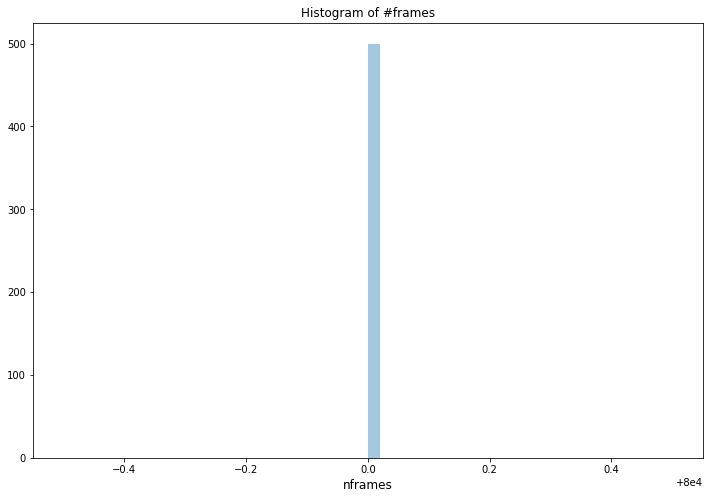

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

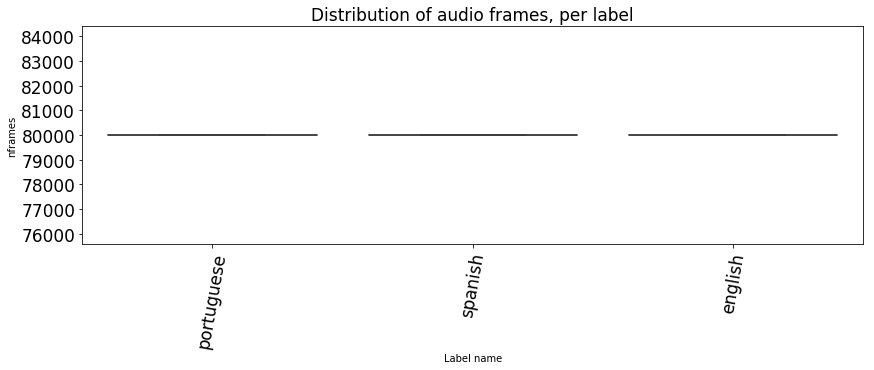

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path    label  \
0    train/en\en_f_5dff2b7b319207972450f91d569b5a16...  english   
425  train/en\en_m_011f3a2d0aa2880305c08b76873c3e10...  english   
426  train/en\en_m_d630900a88e2681c9d5d1026d7025d67...  english   
427  train/en\en_f_5dff2b7b319207972450f91d569b5a16...  english   
428  train/en\en_m_65733942d40b2431cf22fe21495693f7...  english   

                    file_name speed_changing pitch_changing noise_add  \
0    en_f_5dff2b7b31920797245           None           None      None   
425  en_m_011f3a2d0aa2880305c           None           None      None   
426  en_m_d630900a88e2681c9d5           None           None      None   
427  en_f_5dff2b7b31920797245           None           None      None   
428  en_m_65733942d40b2431cf2           None           None      None   

     augmented_data  
0             False  
425           False  
426           False  
427           False  
428           False

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

0

Total number of labels in training data :  3
Labels are :  ['english' 'portuguese' 'spanish']


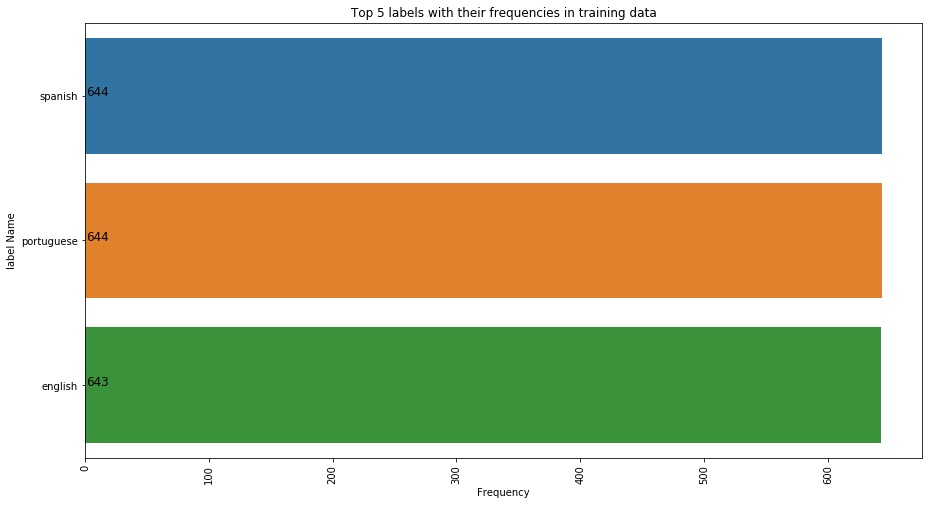

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por gênero

In [22]:
temp = data['gender'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Gender')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por contagem de locutores

In [23]:
speakers_count = dict()
for lang in data['label']:
    speakers_count[lang] = 0
counted = set()
for lang, fname in zip(data['label'], data['file_name']):
    if fname not in counted:
        speakers_count[lang] += 1
        counted.add(fname)
        
df_spk = pandas.DataFrame(data=list(zip(speakers_count.keys() ,speakers_count.values())), 
                          columns=['label', 'Speakers (count)'])
df_spk.head()

label  Speakers (count)
0     english                28
1  portuguese                29
2     spanish                28

In [24]:
temp = df_spk['Speakers (count)']
labels = df_spk['label']
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Speaker (count)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por locutores

count
label   file_name                      
english en_f_058b70233667e1b6450     23
        en_f_10134f409d9b7b0b95f     23
        en_f_17211c49a9b2967b57c     23
        en_f_25836f5c38f5151611d     23
        en_f_31da456c78eb5cf86d2     23

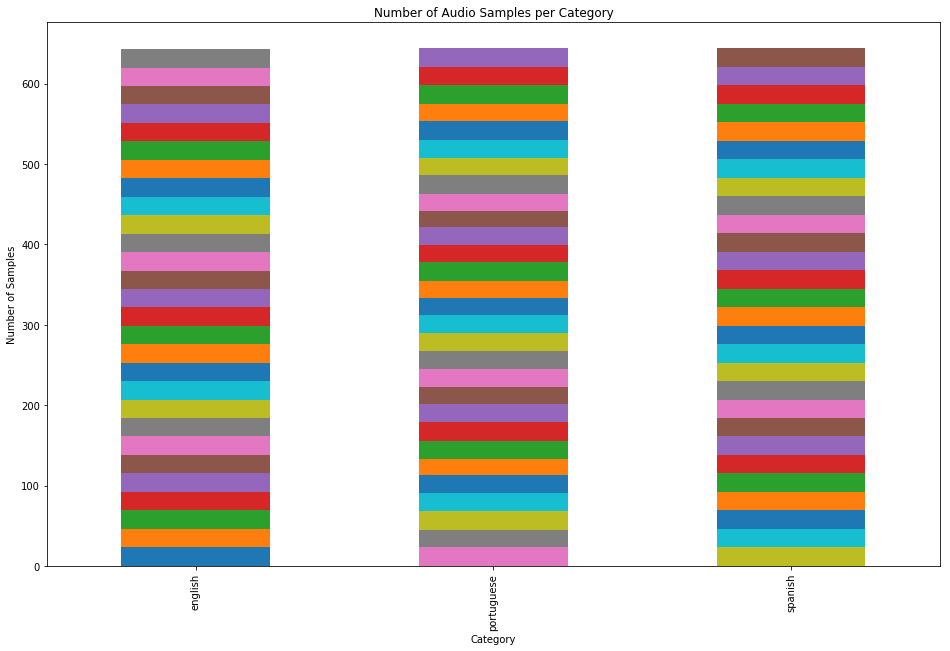

In [25]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['file_name']), 
                        columns=['count', 'label', 'file_name'])
category_group = temp.groupby(['label', 'file_name']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
plot.get_legend().remove()
category_group.head()

## Instâncias por idioma e gênero

count
label      gender       
english    f         322
           m         321
portuguese f         290
           m         354
spanish    f         322
           m         322

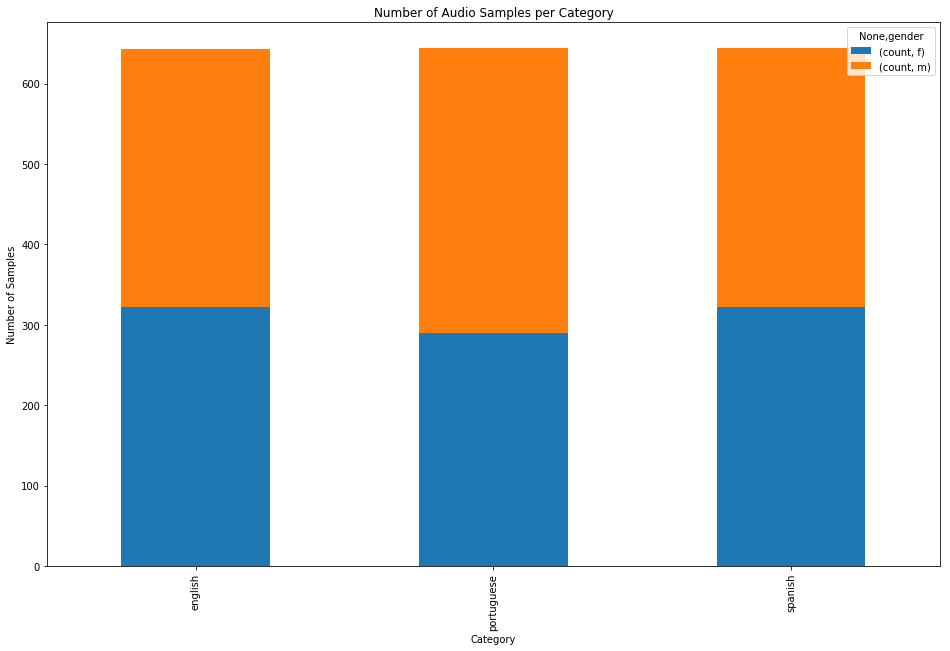

In [26]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['gender']), 
                        columns=['count', 'label', 'gender'])
category_group = temp.groupby(['label', 'gender']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

## Instâncias por _data augmentation_

In [27]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
english    False             643
portuguese False             644
spanish    False             644

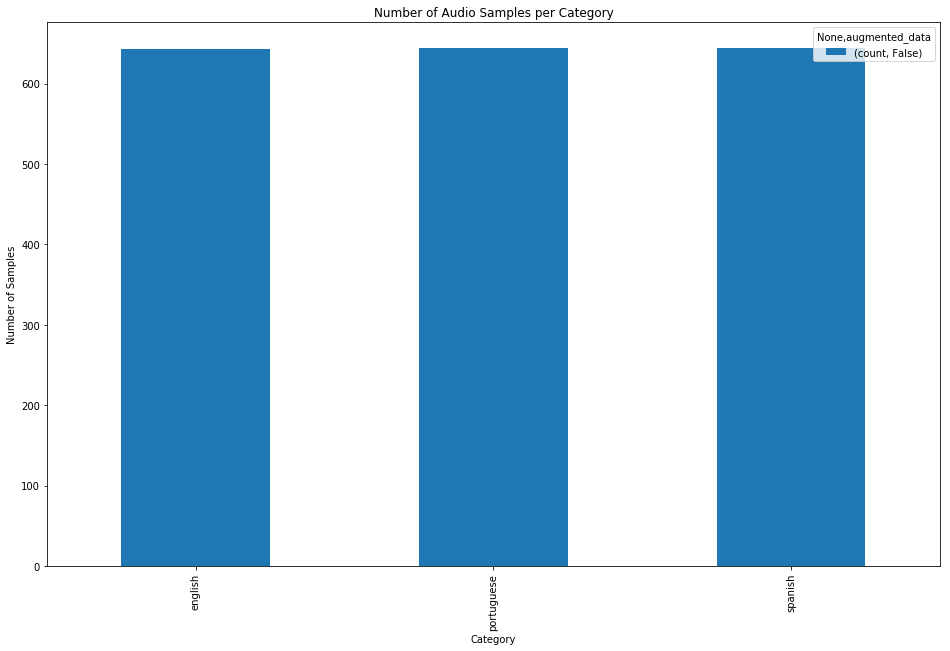

In [28]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add
label      augmented_data                                                  
english    False             643               0               0          0
portuguese False             644               0               0          0
spanish    False             644               0               0          0

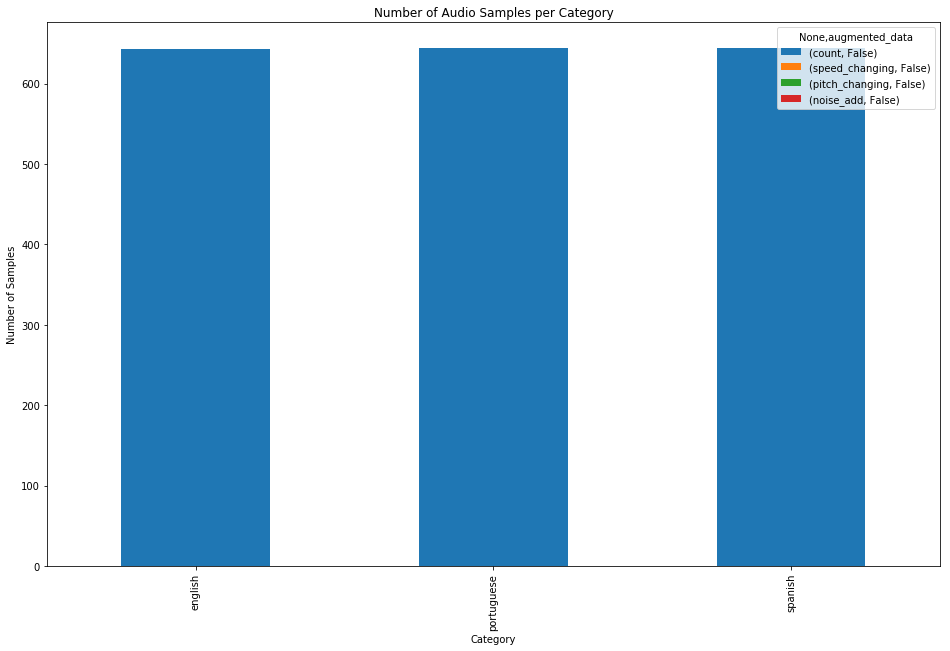

In [29]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'], 
                            data['pitch_changing'], data['noise_add'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

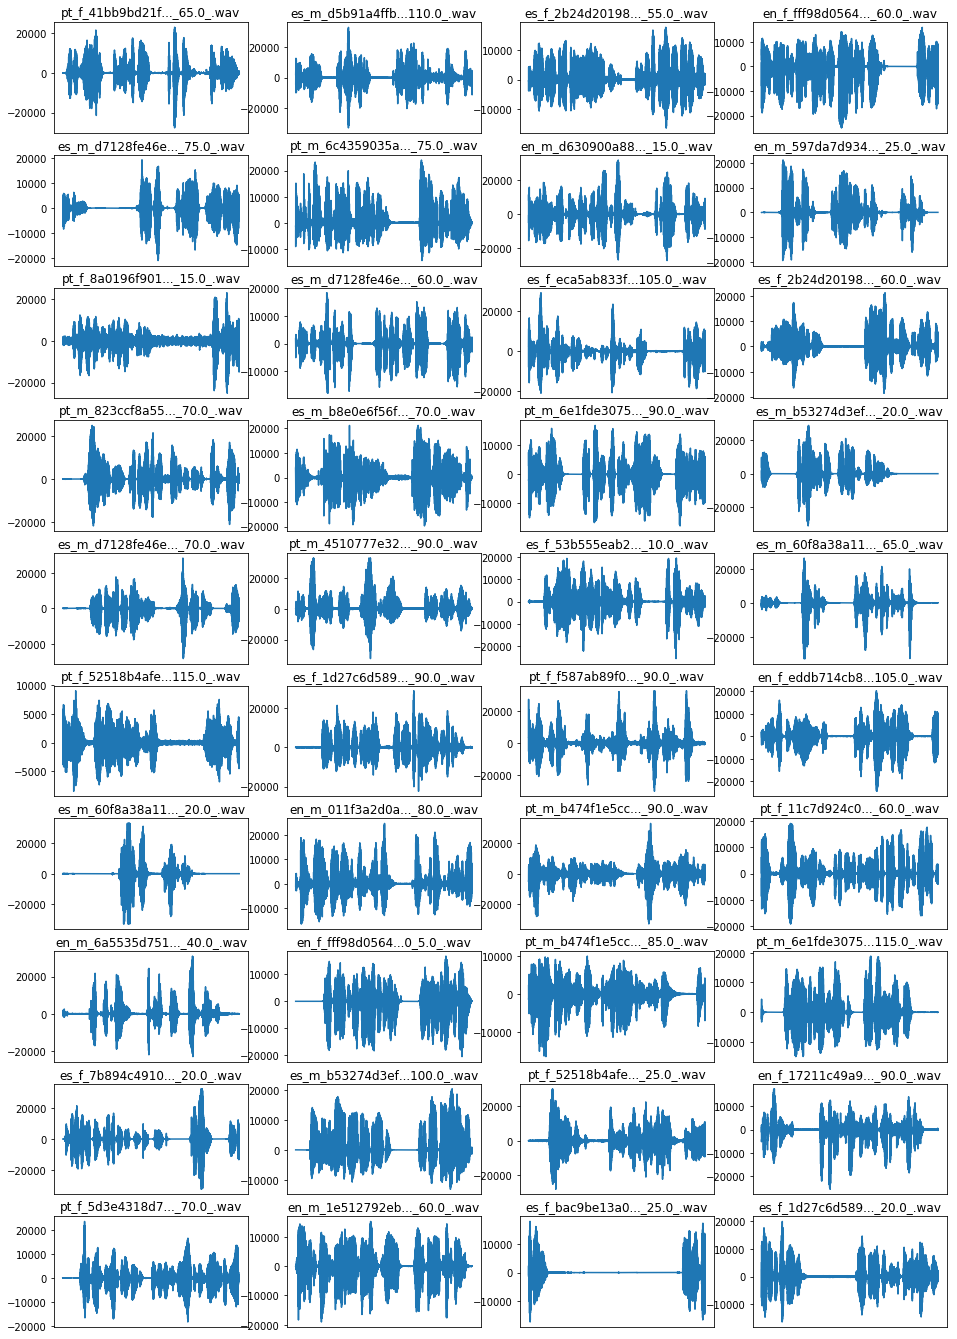

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [31]:
sr, b = wavfile.read(data['file_path'][0])

In [32]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

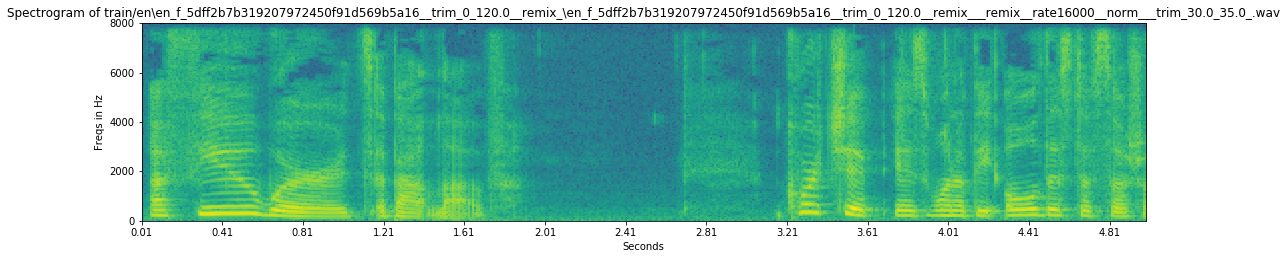

In [33]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [34]:
print("Size of training data", data.shape)

Size of training data (1931, 8)


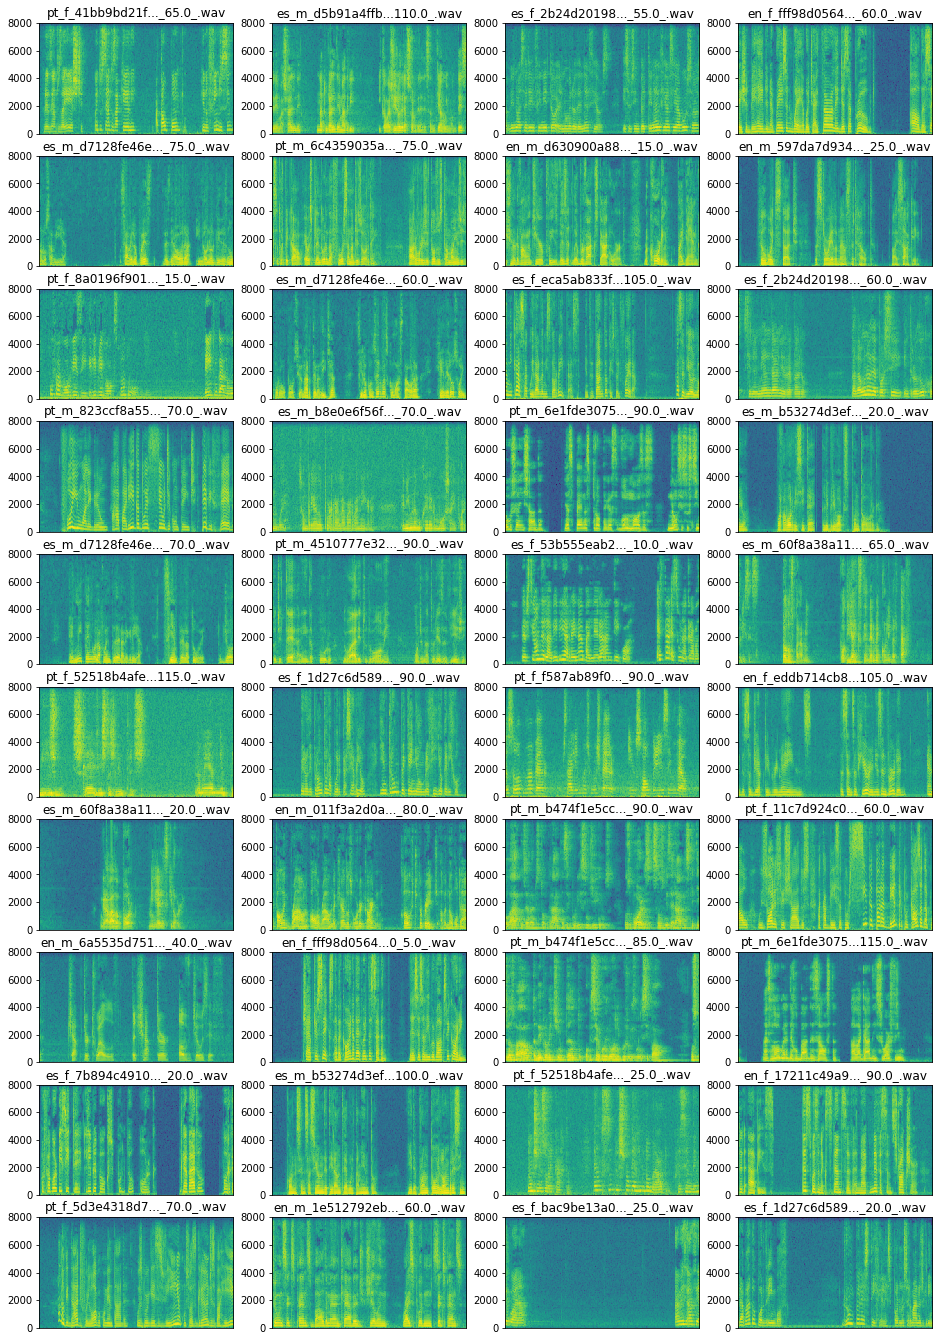

In [35]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [36]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

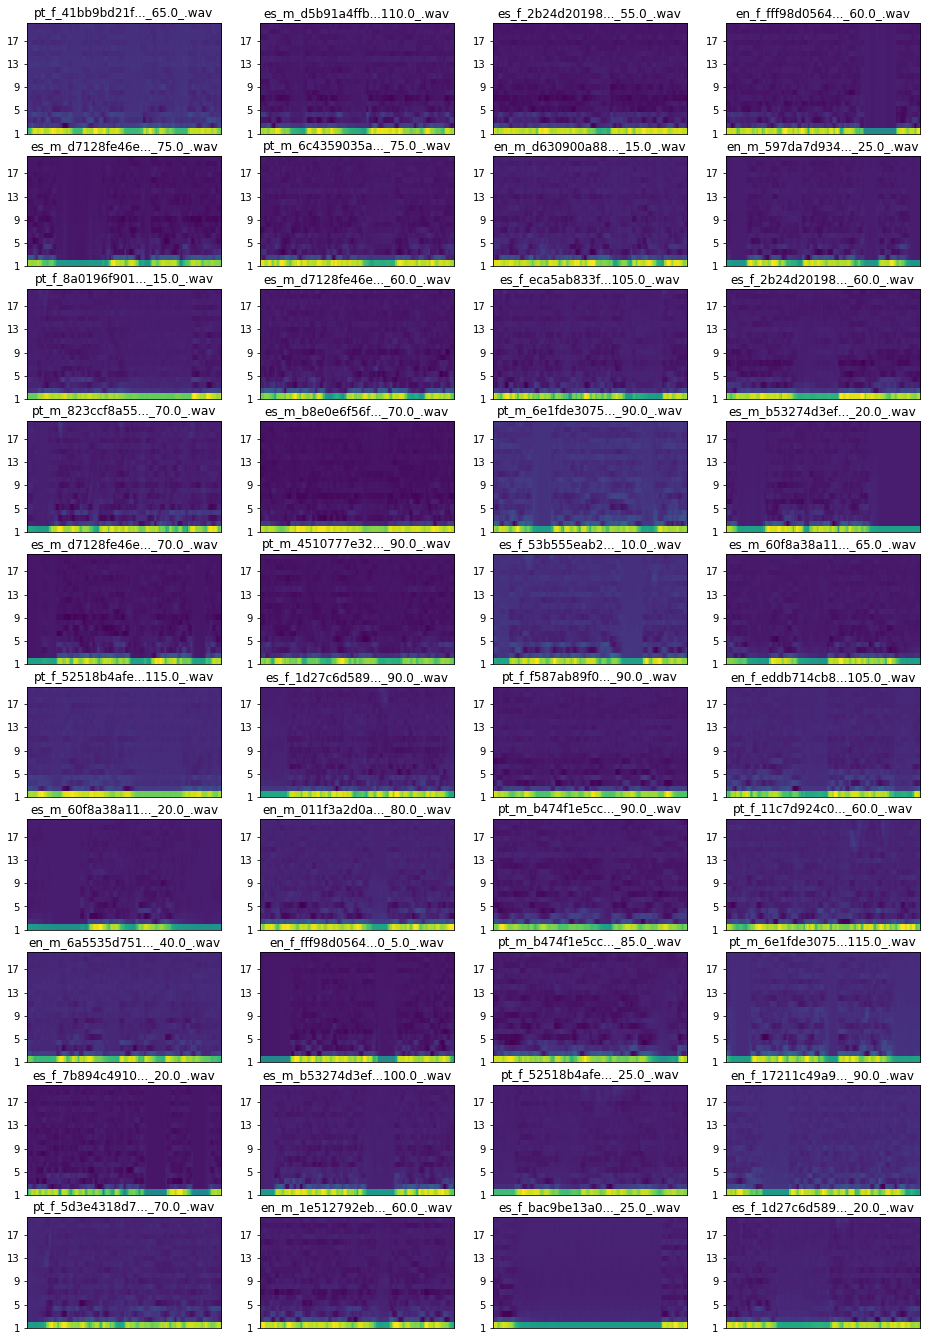

In [37]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [38]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

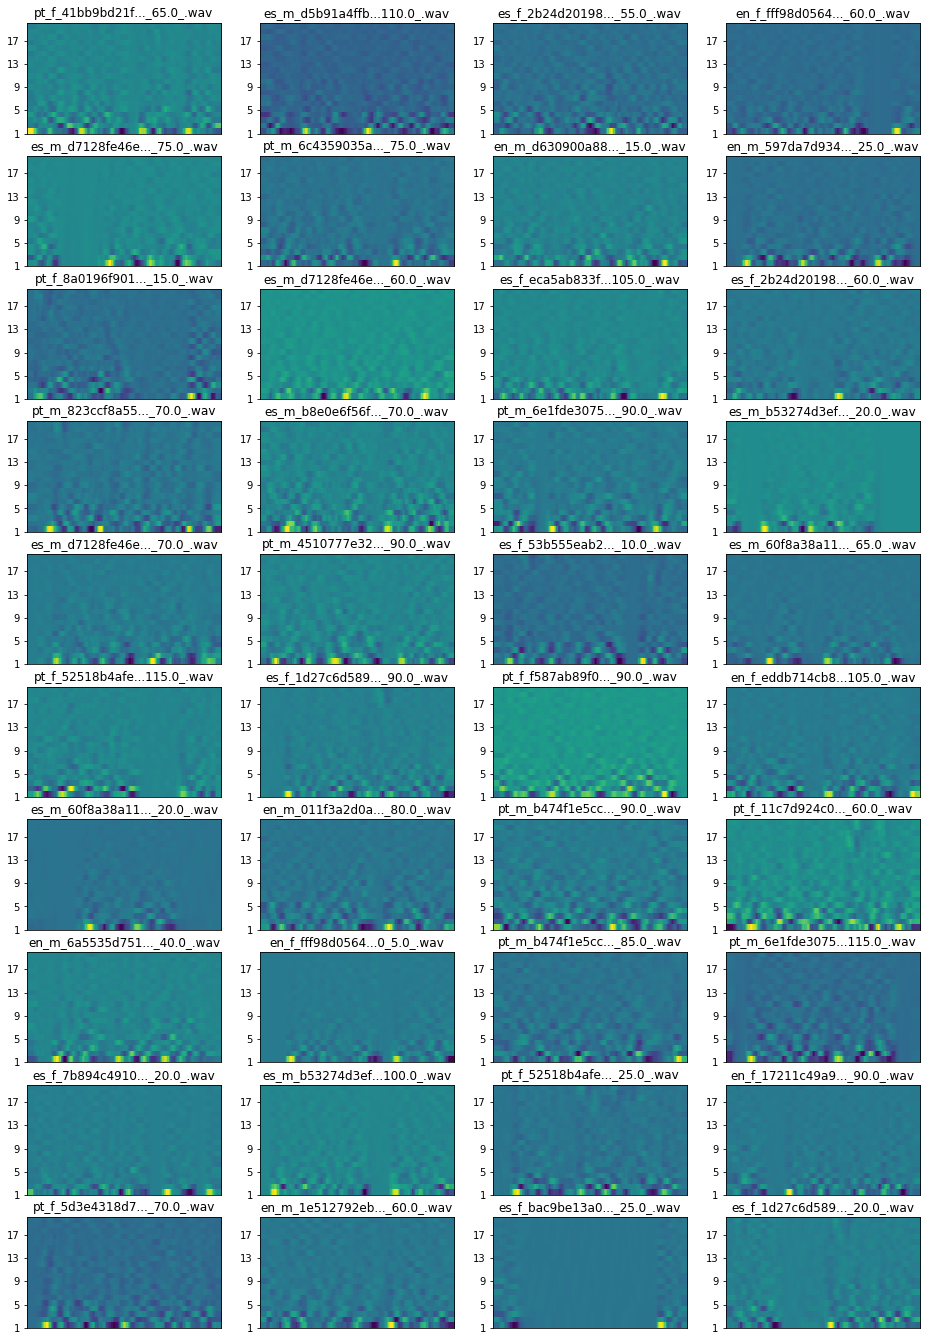

In [39]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [40]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

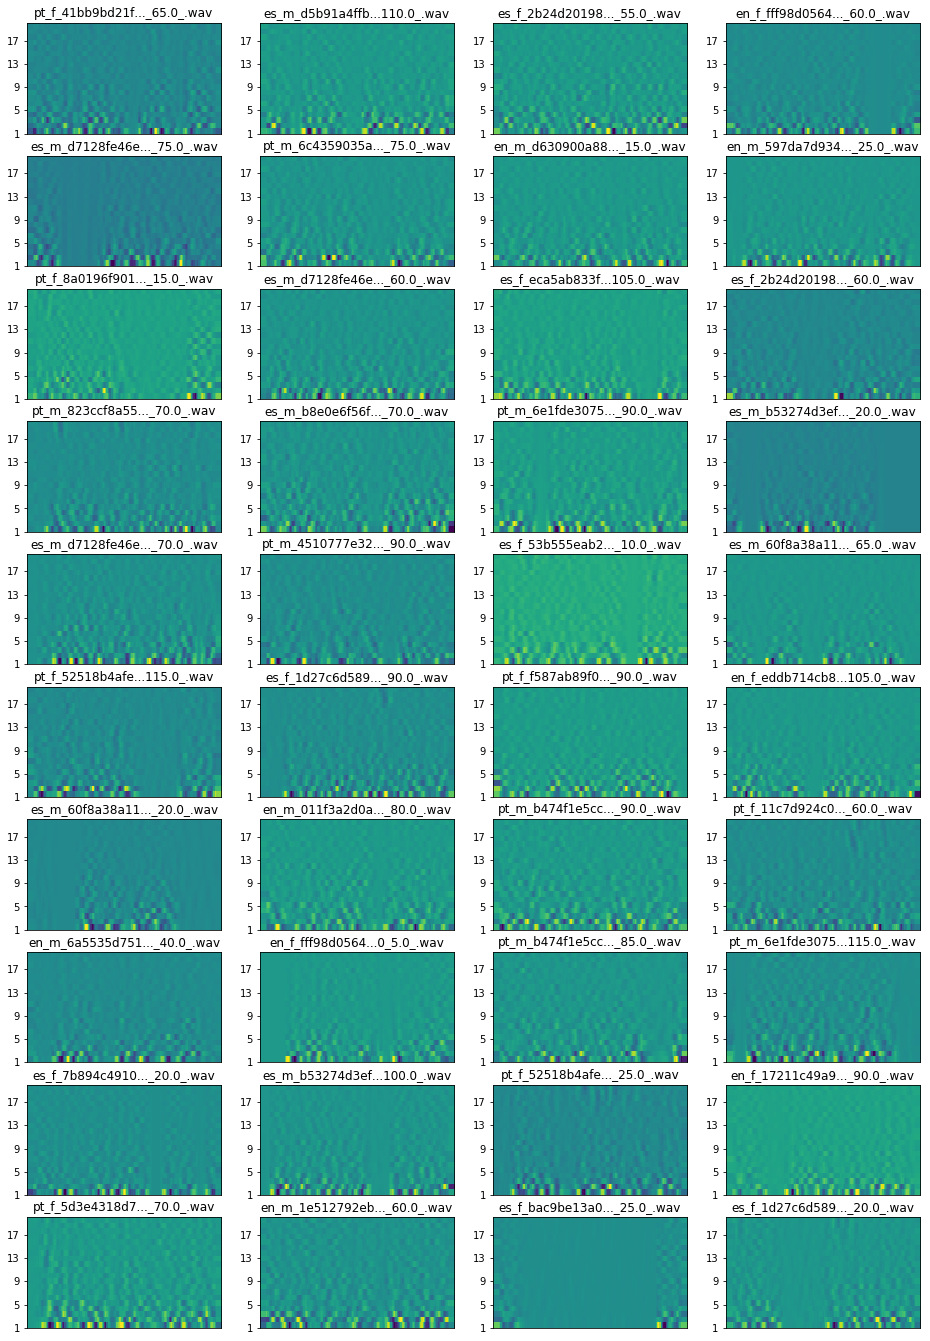

In [41]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [42]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

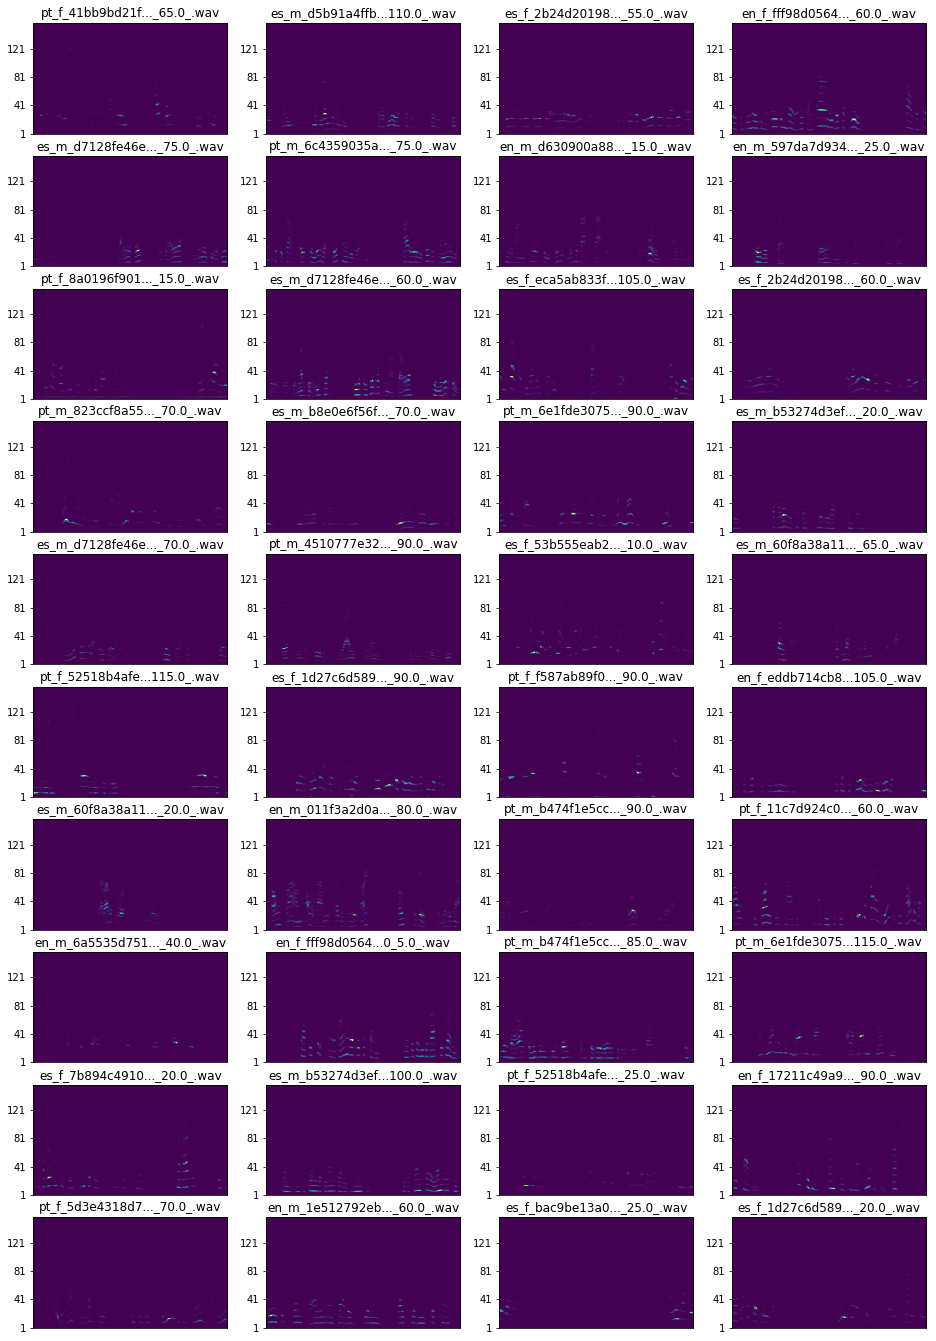

In [43]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  